https://www.transtats.bts.gov/Fields.asp?Table_ID=236

In [1]:
from __future__ import division #, print_function # Imports from __future__ since we're running Python 2

In [2]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
random_state = 0
%matplotlib inline
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
from sklearn.dummy import DummyClassifier
from helpers.feature_engineering import dateStrToDayYear, getMappingOfSimilarCategoricalColumns, \
    compareSimilarCategoricalColumns 
from helpers.my_one_hot_encoder import MyOneHotEncoder
from helpers.py_helpers import is_number
from scipy.stats import skew, kurtosis
from helpers.outliers import MyOutliers
from sklearn.preprocessing import StandardScaler
from helpers.plot_helper import scatter_2d_label
from sklearn.decomposition import PCA # Import the PCA module
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from helpers.performance_issues import subsample_keeping_class_proportions
from sklearn.metrics import f1_score, precision_score

In [4]:
rng = np.random.RandomState(seed=random_state)

In [5]:
n_jobs = 3

# Flying to New York City - Standarization and Dimensionality Reduction

In [6]:
target_col = 'IS_DELAYED'

In [7]:
path_data = os.path.realpath(os.path.join(os.getcwd(), '../Data', 'binary_train_data_numerical_no_outliers.csv'))
assert os.path.isfile(path_data)
path_data

'/home/student/pligor.george@gmail.com/msc_Artificial_Intelligence/dme_Data_Mining/dmedatarats/Data/binary_train_data_numerical_no_outliers.csv'

In [8]:
df = pd.read_csv(path_data, delimiter = ',', header=0)
df.shape

(180133, 533)

In [9]:
df.sample(10, random_state=random_state)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_NUM,DEP_TIME,DEP_DELAY,DEP_DELAY_GROUP,DISTANCE,DISTANCE_GROUP,...,DEP_TIME_BLK_9,DEP_TIME_BLK_10,DEP_TIME_BLK_11,DEP_TIME_BLK_12,DEP_TIME_BLK_13,DEP_TIME_BLK_14,DEP_TIME_BLK_15,DEP_TIME_BLK_16,DEP_TIME_BLK_17,IS_DELAYED
165999,3,7,26,2,2922,520.0,0.0,0.0,281.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
118690,2,4,3,7,1462,641.0,11.0,0.0,762.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
170863,1,2,8,1,942,1116.0,-4.0,-1.0,1089.0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
95968,1,3,24,4,3483,643.0,3.0,0.0,1381.0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
121221,2,4,9,6,234,2239.0,-6.0,-1.0,266.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
151722,2,5,1,7,1485,1955.0,0.0,0.0,950.0,4,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False
8018,1,3,5,6,7406,2015.0,-5.0,-1.0,378.0,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True
30157,1,1,22,5,4462,2151.0,-6.0,-1.0,282.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False
59496,2,5,15,7,359,1752.0,42.0,2.0,2465.0,10,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True
15980,2,6,18,6,3723,1021.0,-4.0,-1.0,289.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [10]:
df.info()  #here we are verifying that everything is numerical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180133 entries, 0 to 180132
Columns: 533 entries, QUARTER to IS_DELAYED
dtypes: bool(1), float64(525), int64(7)
memory usage: 731.3 MB


In [11]:
columns_one_hot_encoded = np.array([col for col in df.columns if is_number(col[-1])])
columns_one_hot_encoded

array(['UNIQUE_CARRIER_0', 'UNIQUE_CARRIER_1', 'UNIQUE_CARRIER_2',
       'UNIQUE_CARRIER_3', 'UNIQUE_CARRIER_4', 'UNIQUE_CARRIER_5',
       'UNIQUE_CARRIER_6', 'UNIQUE_CARRIER_7', 'UNIQUE_CARRIER_8',
       'UNIQUE_CARRIER_9', 'UNIQUE_CARRIER_10', 'ORIGIN_0', 'ORIGIN_1',
       'ORIGIN_2', 'ORIGIN_3', 'ORIGIN_4', 'ORIGIN_5', 'ORIGIN_6',
       'ORIGIN_7', 'ORIGIN_8', 'ORIGIN_9', 'ORIGIN_10', 'ORIGIN_11',
       'ORIGIN_12', 'ORIGIN_13', 'ORIGIN_14', 'ORIGIN_15', 'ORIGIN_16',
       'ORIGIN_17', 'ORIGIN_18', 'ORIGIN_19', 'ORIGIN_20', 'ORIGIN_21',
       'ORIGIN_22', 'ORIGIN_23', 'ORIGIN_24', 'ORIGIN_25', 'ORIGIN_26',
       'ORIGIN_27', 'ORIGIN_28', 'ORIGIN_29', 'ORIGIN_30', 'ORIGIN_31',
       'ORIGIN_32', 'ORIGIN_33', 'ORIGIN_34', 'ORIGIN_35', 'ORIGIN_36',
       'ORIGIN_37', 'ORIGIN_38', 'ORIGIN_39', 'ORIGIN_40', 'ORIGIN_41',
       'ORIGIN_42', 'ORIGIN_43', 'ORIGIN_44', 'ORIGIN_45', 'ORIGIN_46',
       'ORIGIN_47', 'ORIGIN_48', 'ORIGIN_49', 'ORIGIN_50', 'ORIGIN_51',
       'ORIGIN_

In [12]:
columns_not_one_hot = np.array([col for col in df.columns if not is_number(col[-1])])
columns_not_one_hot

array(['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_NUM',
       'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_GROUP', 'DISTANCE',
       'DISTANCE_GROUP', 'YDAY', 'IS_DELAYED'], 
      dtype='|S15')

In [13]:
df[columns_not_one_hot].describe()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_NUM,DEP_TIME,DEP_DELAY,DEP_DELAY_GROUP,DISTANCE,DISTANCE_GROUP,YDAY
count,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000
mean,2.485286,6.469853,15.779080,3.901384,1656.073862,1404.143255,22.556311,0.982335,1052.818340,4.701165,182.171929
std,1.099547,3.376037,8.789477,1.967829,1532.067779,518.063078,39.313829,2.671317,699.837374,2.762467,103.605450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-31.000000,-2.000000,94.000000,1.000000,1.000000
25%,2.000000,4.000000,8.000000,2.000000,458.000000,958.000000,-4.000000,-1.000000,544.000000,3.000000,92.000000
50%,2.000000,6.000000,16.000000,4.000000,1269.000000,1438.000000,3.000000,0.000000,950.000000,4.000000,182.000000
75%,3.000000,9.000000,23.000000,5.000000,2168.000000,1833.000000,37.000000,2.000000,1381.000000,6.000000,269.000000
max,4.000000,12.000000,31.000000,7.000000,7439.000000,2400.000000,180.000000,12.000000,2586.000000,11.000000,366.000000


In [14]:
Xtrain = df.drop(labels=[target_col], axis=1)

In [15]:
ytrain = df[target_col]

In [16]:
columns_to_explore = columns_not_one_hot[columns_not_one_hot != target_col]
#assert (len(columns_to_explore) + 1) == len(columns_not_one_hot)
len(columns_to_explore)

11

## Standarize attributes
Note that since the one hot encoded attributes might not come from a gaussian distribution, it makes no sense to handle them like that: https://www.quora.com/How-bad-is-it-to-standardize-dummy-variables

In [17]:
ss = StandardScaler()

In [18]:
Xtrain[columns_one_hot_encoded].describe()

,UNIQUE_CARRIER_0,UNIQUE_CARRIER_1,UNIQUE_CARRIER_2,UNIQUE_CARRIER_3,UNIQUE_CARRIER_4,UNIQUE_CARRIER_5,UNIQUE_CARRIER_6,UNIQUE_CARRIER_7,UNIQUE_CARRIER_8,UNIQUE_CARRIER_9,...,DEP_TIME_BLK_8,DEP_TIME_BLK_9,DEP_TIME_BLK_10,DEP_TIME_BLK_11,DEP_TIME_BLK_12,DEP_TIME_BLK_13,DEP_TIME_BLK_14,DEP_TIME_BLK_15,DEP_TIME_BLK_16,DEP_TIME_BLK_17
count,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000,180133.0,180133.000000,180133.000000,180133.000000,180133.000000,...,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000
mean,0.001282,0.251770,0.237902,0.091460,0.004552,0.0,0.020918,0.015433,0.042191,0.023072,...,0.055642,0.067761,0.059661,0.077332,0.062504,0.066307,0.052217,0.041769,0.024915,0.013457
std,0.035788,0.434031,0.425800,0.288263,0.067316,0.0,0.143110,0.123268,0.201025,0.150132,...,0.229230,0.251336,0.236859,0.267118,0.242069,0.248818,0.222465,0.200062,0.155866,0.115220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
Xss = Xtrain.copy()

In [20]:
Xss[columns_to_explore] = ss.fit_transform(Xtrain[columns_to_explore])

In [21]:
Xss.describe()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_NUM,DEP_TIME,DEP_DELAY,DEP_DELAY_GROUP,DISTANCE,DISTANCE_GROUP,...,DEP_TIME_BLK_8,DEP_TIME_BLK_9,DEP_TIME_BLK_10,DEP_TIME_BLK_11,DEP_TIME_BLK_12,DEP_TIME_BLK_13,DEP_TIME_BLK_14,DEP_TIME_BLK_15,DEP_TIME_BLK_16,DEP_TIME_BLK_17
count,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,...,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000,180133.000000
mean,-7.773983e-16,6.587020e-17,2.750966e-17,1.354079e-15,4.147504e-17,1.918213e-16,1.953434e-16,-2.899795e-15,3.548340e-16,1.352127e-15,...,0.055642,0.067761,0.059661,0.077332,0.062504,0.066307,0.052217,0.041769,0.024915,0.013457
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,...,0.229230,0.251336,0.236859,0.267118,0.242069,0.248818,0.222465,0.200062,0.155866,0.115220
min,-1.350820e+00,-1.620204e+00,-1.681456e+00,-1.474413e+00,-1.080291e+00,-2.708448e+00,-1.362280e+00,-1.116432e+00,-1.370063e+00,-1.339808e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.413519e-01,-7.315854e-01,-8.850472e-01,-9.662371e-01,-7.820001e-01,-8.611779e-01,-6.754973e-01,-7.420838e-01,-7.270543e-01,-6.158155e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-4.413519e-01,-1.391733e-01,2.513468e-02,5.011427e-02,-2.526487e-01,6.535273e-02,-4.974424e-01,-3.677355e-01,-1.469179e-01,-2.538192e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.681160e-01,7.494450e-01,8.215438e-01,5.582900e-01,3.341416e-01,8.278103e-01,3.673956e-01,3.809610e-01,4.689412e-01,4.701733e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.377584e+00,1.638063e+00,1.731726e+00,1.574641e+00,3.774599e+00,1.922275e+00,4.004803e+00,4.124444e+00,2.190775e+00,2.280155e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
Xss.shape

(180133, 532)

### save normalized data

In [23]:
full_data = pd.concat( (Xss, ytrain), axis=1 )

In [24]:
# full_data.to_csv(
#     os.path.realpath(os.path.join(os.getcwd(), '../Data', 'binary_train_data_numerical_no_outliers_normalized.csv')),
#     index=False)

# Dimensionality Reduction

## Kernel PCA

In [25]:
def getKernelPCA_X(kernel, X=Xss, degree=3, gamma=None, n_jobs=n_jobs):
    return KernelPCA(n_components=2, random_state=random_state, kernel=kernel, degree=degree, gamma=gamma,
                    n_jobs=n_jobs).fit_transform(X)

### rbf

In [26]:
def kernelPCAwithRBF():
    kernel = 'rbf'
    gamma = 0.1
    nn = 30000
    Xsub, ysub = subsample_keeping_class_proportions(XX=Xss, yy=ytrain, nn=nn, seed=random_state)
    curX = Xsub  #Xss
    cur_y = ysub  #ytrain

    plt.figure(figsize=(12,7))
    scatter_2d_label(
        getKernelPCA_X(kernel=kernel,
                       X=curX,
                       gamma=gamma,
                       n_jobs=1),
            y=cur_y, alpha=0.2, s=2, lw=2)
    plt.title('Labelled data in PCA space with kernel {}'.format(kernel))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    # Add a legend outside the plot at specified point
    plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
    plt.show()
    
kernelPCAwithRBF()

MemoryError: 

For once again the RBF kernel seems to provide the best seperation of the classes.

In particular the hyperparameter gamma = 0.1 brought, visually evaluated, the best separation of the classes with lots of delayed instances located at the centre and lots of non-delayed instances located at the periphery

### Poly

In [ ]:
kernel = 'poly'
degree = 10

plt.figure(figsize=(12,7))
scatter_2d_label(getKernelPCA_X(kernel=kernel, X=Xsub, degree=degree), y=ysub, alpha=0.3, s=2, lw=2)
plt.title('Labelled data in PCA space with kernel {}'.format(kernel))
plt.xlabel('component 1')
plt.ylabel('component 2')
# Add a legend outside the plot at specified point
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
plt.show()

After trying different kinds of degrees of polynomials we see that we get only a distorted version of the original PCA which is still not useful for our classification

### Cosine

In [ ]:
kernel = 'cosine'

plt.figure(figsize=(12,7))
scatter_2d_label(getKernelPCA_X(kernel=kernel, X=Xsub), y=ysub, alpha=0.3, s=2, lw=2)
plt.title('Labelled data in PCA space with kernel {}'.format(kernel))
plt.xlabel('component 1')
plt.ylabel('component 2')
# Add a legend outside the plot at specified point
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
plt.show()

cosine has poor performance as well

### sigmoid

In [ ]:
kernel = 'sigmoid'

plt.figure(figsize=(12,7))
scatter_2d_label(getKernelPCA_X(kernel=kernel, X=Xsub), y=ysub, alpha=0.3, s=2, lw=2)
plt.title('Labelled data in PCA space with kernel {}'.format(kernel))
plt.xlabel('component 1')
plt.ylabel('component 2')
# Add a legend outside the plot at specified point
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
plt.show()

sigmoid kernel has not helped either

## subsampling

In [24]:
nn = 10000
Xsub, ysub = subsample_keeping_class_proportions(XX=Xss, yy=ytrain, nn=nn, seed=random_state)

## Isomap

In [25]:
isomap = Isomap(n_components=2, n_neighbors=10, n_jobs=4)

In [26]:
Xisomap = isomap.fit_transform(Xsub)

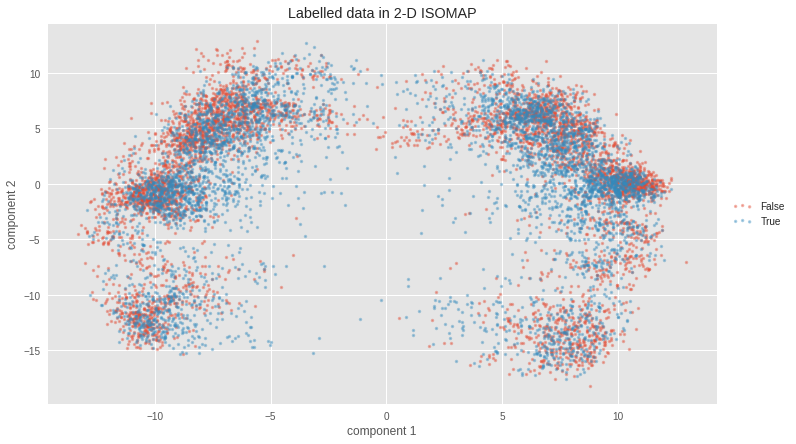

blue is delayed and red is arrived on time


In [27]:
plt.figure(figsize=(12,7))
scatter_2d_label(Xisomap, y=ysub, alpha=0.4, s=2, lw=2)
plt.title('Labelled data in 2-D ISOMAP')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3) # Add a legend outside the plot at specified point
#plt.legend(loc='best', scatterpoints=3) # Ask matplotlib to place the legend where it thinks best
plt.show()
print "blue is delayed and red is arrived on time"

We couldn't say that this MDS with 10 neighbors separates the classes well enough. No real pattern is visible here

In [ ]:
isomap = Isomap(n_components=2, n_neighbors=50, n_jobs=4)

In [ ]:
Xisomap = isomap.fit_transform(Xsub)

In [ ]:
plt.figure(figsize=(12,7))
scatter_2d_label(Xisomap, y=ysub, alpha=0.4, s=2, lw=2)
plt.title('Labelled data in 2-D ISOMAP')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3) # Add a legend outside the plot at specified point
#plt.legend(loc='best', scatterpoints=3) # Ask matplotlib to place the legend where it thinks best
plt.show()
print "blue is delayed and red is arrived on time"

with 50 neighbors we have the data separated in different clusters but not with the clusters that we want. The delayed and nondelayed flights are not separated

## MDS

In [ ]:
mds = MDS(n_components=2, max_iter=100, n_init=2, random_state=random_state, n_jobs=-1)

In [ ]:
Xmds = mds.fit_transform(Xsub)

In [ ]:
plt.figure(figsize=(12,7))
scatter_2d_label(Xmds, y=ysub, alpha=0.4, s=2, lw=2)
plt.title('Labelled data in 2-D MDS')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3) # Add a legend outside the plot at specified point
#plt.legend(loc='best', scatterpoints=3) # Ask matplotlib to place the legend where it thinks best
plt.show()
print "blue is delayed and red is arrived on time"

Well there is some separation since on the peripherals we have only blue dots but in general the vast majority is mixed with the red dots

## PCA

In [ ]:
X_pca_2d = PCA(n_components=2, random_state=random_state).fit_transform(Xss)
X_pca_2d.shape

In [ ]:
plt.figure(figsize=(12,7))
scatter_2d_label(X_pca_2d, y=ytrain, alpha=0.2, s=1, lw=1)
plt.title('Labelled data in 2-D PCA space')
plt.xlabel('Principal component score 1')
plt.ylabel('Principal component score 2')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3) # Add a legend outside the plot at specified point
#plt.legend(loc='best', scatterpoints=3) # Ask matplotlib to place the legend where it thinks best
plt.show()
print "blue is delayed and red is arrived on time"

#### Conclusion
With the current feature selection and using PCA we do not see any separation among the classes.

No reason to make a KDE plot

## t-SNE

In [61]:
n_tsne = 3000

In [62]:
full_data = pd.concat( (Xss, ytrain), axis=1)

In [63]:
delayed_samples = full_data[ytrain].sample(n_tsne, random_state=random_state)

In [64]:
nondelayed_samples = full_data[ytrain == False].sample(n_tsne, random_state=random_state)

In [65]:
subsampled = shuffle( pd.concat((delayed_samples, nondelayed_samples)) , random_state=random_state)
subsampled.shape

(6000, 533)

In [66]:
Xsubsampled = subsampled.drop(labels=[target_col], axis=1)
y_subsampled = subsampled[target_col]

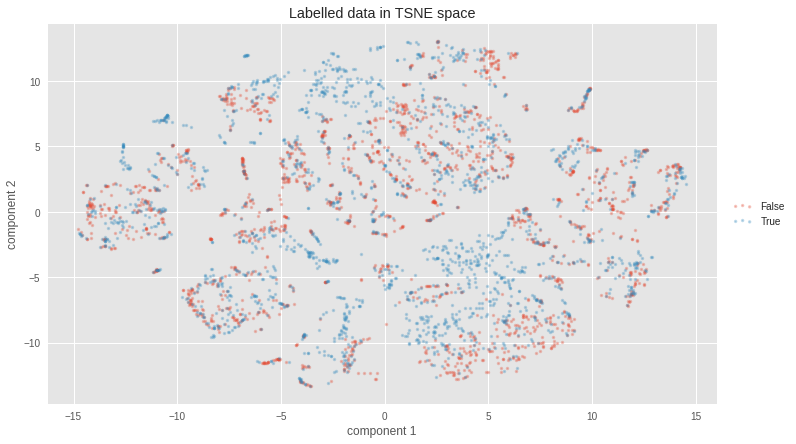

In [58]:
tSne = TSNE(n_components=2, perplexity=30, random_state=random_state)
Xtsne = tSne.fit_transform(Xsubsampled)
plt.figure(figsize=(12,7))
scatter_2d_label(Xtsne, y=y_subsampled, alpha=0.3, s=2, lw=2)
plt.title('Labelled data in TSNE space')
plt.xlabel('component 1')
plt.ylabel('component 2')
# Add a legend outside the plot at specified point
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
plt.show()

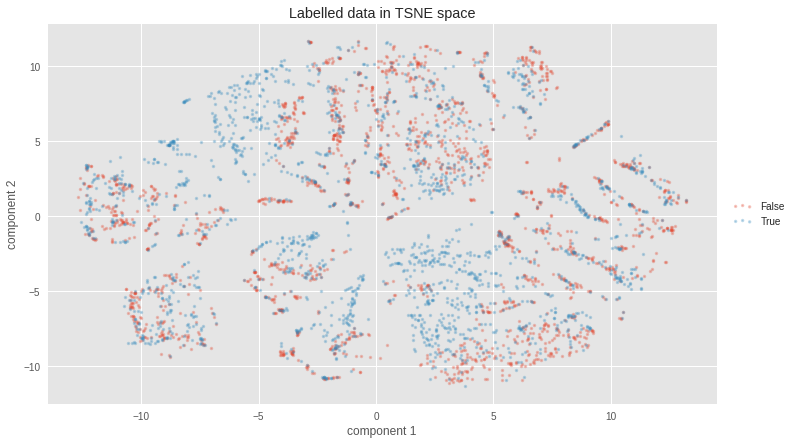

In [59]:
tSne = TSNE(n_components=2, perplexity=50, random_state=random_state)
Xtsne = tSne.fit_transform(Xsubsampled)
plt.figure(figsize=(12,7))
scatter_2d_label(Xtsne, y=y_subsampled, alpha=0.3, s=2, lw=2)
plt.title('Labelled data in TSNE space')
plt.xlabel('component 1')
plt.ylabel('component 2')
# Add a legend outside the plot at specified point
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
plt.show()

#### Conclusion
We have subsampled our flight data a lot in order to make it computationally feasible for t-SNE which is highly expected to affect the generalization of our algorithm

The results are not amazing. We see that by using a relatively high perplexity of 50 we have some visible separation of some of the delayed flights but still a lot of them are mixed with the non-delayed flights

# Dummy Classifier

In [26]:
dc = DummyClassifier(random_state=random_state).fit(Xss, ytrain)
dc

DummyClassifier(constant=None, random_state=0, strategy='stratified')

In [27]:
dc.score(Xss, ytrain)

0.50231218044444936

So our baseline here is merely ~50%

Our classification ought to outperform this number in order to be taken seriously into account.

But this analysis refers to the classification accuracy. Since later we might have an imbalanced classification problem we need another metric. We are going to use the most straightforward one which is the F1 score

In [28]:
preds = dc.predict(Xss)
preds.shape

(180133,)

In [29]:
preds[:5]

array([ True,  True,  True,  True, False], dtype=bool)

In [30]:
arr = f1_score(y_true=ytrain, y_pred=preds, average=None)  #'binary'
arr
#Note first class is the False (0) (here the arrived ok flights) class
#while the second class is the True(1) (the delayed flights) class

array([ 0.51742959,  0.48621698])

In [31]:
precision_score(y_true=ytrain, y_pred=preds)

0.48557692307692307

In [121]:
np.argwhere(ytrain).shape

(87130, 1)

In [122]:
# tp = 0
# fp = 0
# fn = 0
# for pred, truth in zip(preds, ytrain):
#     if truth and pred == truth:
#         tp += 1
    
#     if truth and pred != truth:
#         fp += 1
        
#     if not truth and pred != truth:
#         fn += 1

# tp, fp, fn

In [137]:
truths = ytrain.copy()# == False

In [138]:
#preds = preds == False

In [139]:
tp = np.sum( np.logical_and(preds == truths, truths) )
tp

42420

In [140]:
fp = np.sum( np.logical_and(preds != truths, truths) )
fp

44710

In [141]:
fn = np.sum( np.logical_and(preds != truths, truths == False) )
fn

44940

In [142]:
p = tp / (tp + fp)
p

0.48685871685986459

In [143]:
r = tp / (tp + fn)
r

0.48557692307692307

In [144]:
2 * (p*r / (p+r))

0.48621697518482432